In [1]:
import pandas as pd
pd.options.display.max_columns = None

import talib
import numpy as np

import math

In [2]:
eur_usd = pd.read_csv('./Data/EURUSD/EURUSD.csv')
eur_usd

,Gmt time,Open,High,Low,Close,Volume
0,04.05.2003 21:00:00.000,1.12354,1.12354,1.12279,1.12331,24206.599600
1,04.05.2003 22:00:00.000,1.12290,1.12317,1.12240,1.12251,23023.599600
2,04.05.2003 23:00:00.000,1.12255,1.12255,1.12176,1.12179,24839.699200
3,05.05.2003 00:00:00.000,1.12177,1.12318,1.12166,1.12274,23463.199200
4,05.05.2003 01:00:00.000,1.12242,1.12276,1.12119,1.12150,25406.599600
...,...,...,...,...,...,...
108023,18.08.2020 17:00:00.000,1.19364,1.19384,1.19299,1.19320,0.008529
108024,18.08.2020 18:00:00.000,1.19319,1.19389,1.19285,1.19382,0.004622
108025,18.08.2020 19:00:00.000,1.19382,1.19385,1.19306,1.19334,0.005943
108026,18.08.2020 20:00:00.000,1.19335,1.19384,1.19296,1.19317,0.002447


In [3]:
eur_usd.rename(columns={'Gmt time' : 'date', 
                   'Open':'open',
                   'High':'high',
                   'Low':'low',
                   'Close':'close',
                   'Volume':'volume'}, inplace=True)

eur_usd["date"] = pd.to_datetime(eur_usd['date'])
eur_usd['date'] = pd.to_datetime(eur_usd['date'], format='%Y-%m-%d %H:%M:%S')
eur_usd.sort_values('date', inplace=True)
eur_usd.reset_index(inplace=True, drop=True)
eur_usd

,date,open,high,low,close,volume
0,2003-01-06 21:00:00,1.17149,1.17476,1.17115,1.17145,24919.8008
1,2003-01-06 22:00:00,1.17128,1.17181,1.17073,1.17133,22762.6992
2,2003-01-06 23:00:00,1.17154,1.17276,1.17107,1.17213,24167.3008
3,2003-01-07 00:00:00,1.15217,1.15281,1.15148,1.15185,24066.8008
4,2003-01-07 01:00:00,1.15214,1.15408,1.15180,1.15247,24589.4004
...,...,...,...,...,...,...
108023,2020-12-08 19:00:00,1.17842,1.17897,1.17828,1.17874,29280.2205
108024,2020-12-08 20:00:00,1.17874,1.17904,1.17844,1.17849,2165.6600
108025,2020-12-08 21:00:00,1.17850,1.17883,1.17808,1.17836,555.5914
108026,2020-12-08 22:00:00,1.17848,1.17910,1.17845,1.17882,1475.2500


In [4]:
def create_target(close, periods_fordward):
    return np.where(close.shift(-periods_fordward) > close, 1, 0)

In [5]:
def get_all_indicators(dataframe):
    df = dataframe.copy()    
    df["rsi"] = talib.RSI(df["close"], timeperiod=14)
    df["ema_12"] = talib.EMA(df["close"], timeperiod=12)
    df["ema_26"] = talib.EMA(df["close"], timeperiod=26) 

    upper_band, middle_band, lower_band = talib.BBANDS(df["close"], timeperiod=20, 
                                                nbdevup=2, nbdevdn=2, matype=0)

    df["upper_bband"] = upper_band
    df["middle_bband"] = middle_band
    df["lower_bband"] = lower_band


    macd, macd_signal, macd_hist = talib.MACD(df["close"], fastperiod=12, slowperiod=26, 
                                        signalperiod=9)

    df["macd"] = macd 
    df["macd_signal"] = macd_signal 
    df["macd_hist"] = macd_hist
    
    k, d = talib.STOCH(df["high"], df["low"], df["close"], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

    df["k"] = k
    df["d"] = d
    
    return df

In [6]:
def make_feature_engineering(df):
    
    df['percentage_price_change'] = df.close.pct_change()
    
    #Date
    df["date"] = pd.to_datetime(df.date)
    df["day"] = df["date"].dt.day
    df["day_of_week"] = df["date"].dt.weekday
    df["week"] = df["date"].dt.isocalendar().week
    df["month"] = df["date"].dt.month
    df["quarter"] = df["date"].dt.quarter
    df["year"] = df["date"].dt.year
    
    #RSI
    cut_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    cut_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    df['discrete_rsi'] = pd.cut(df['rsi'], bins=cut_bins, labels=cut_labels)
    
    #EMA
    df['discrete_ema_12'] = np.where(df['close'] > df['ema_12'], 1, 0)
    df['discrete_ema_26'] = np.where(df['close'] > df['ema_26'], 1, 0)
    df['discrete_ema12_ema26'] = np.where(df['ema_12'] > df['ema_26'], 1, 0)
    
    #Bolinger bands
    df['discrete_bollinger_bands'] = 0
    df.loc[df.close > df.upper_bband, 'discrete_bollinger_bands'] = 1
    df.loc[df.close < df.lower_bband, 'discrete_bollinger_bands'] = -1
    df['b_percentage'] = round((df.close - df.lower_bband) / (df.upper_bband - df.lower_bband)*100)
    df = df.drop(df[df.b_percentage == math.inf].index)
    
    #MACD
    df['discrete_macd_signal'] = np.where(df['macd_signal'] > 0, 1, 0)
    df['discrete_macd_hist'] = np.where(df['macd_hist'] > 0, 1, 0)
    df['discrete_macd_signal_hist'] = np.where(df['macd_signal'] > df['macd_hist'], 1, 0)

    #Stochastic
    df['discrete_stochastic'] = pd.cut(df['rsi'], bins=cut_bins, labels=cut_labels)   
    df['discrete_kd'] = np.where(df['k'] > df['d'], 1, 0)
    
    #Candles Features
    df['distance_close_ema_12'] = np.absolute(df['close'] - df['ema_12'])
    df['distance_close_ema_26'] = np.absolute(df['close'] - df['ema_26'])
    df['distance_close_upper_bband'] = np.absolute(df['close'] - df['upper_bband'])
    df['distance_close_middle_bband'] = np.absolute(df['close'] - df['middle_bband'])
    df['distance_close_lower_bband'] = np.absolute(df['close'] - df['lower_bband'])

    df['distance_high_low'] = np.absolute(df['high'] - df['low'])
    df['distance_open_close'] = np.absolute(df['open'] - df['close'])
    df['distance_high_open'] = np.absolute(df['high'] - df['open'])
    df['distance_high_close'] = np.absolute(df['high'] - df['close'])
    df['distance_open_low'] = np.absolute(df['open'] - df['low'])
    df['distance_close_low'] = np.absolute(df['close'] - df['low'])

    df['bullish_candle'] = np.where(df['close'] > df['open'], 1, 0)

    #Shift
    columns_to_shift = ['percentage_price_change',
                        'discrete_rsi',
                        'discrete_ema12_ema26',
                        'discrete_ema_12',
                        'discrete_ema_26',
                        'discrete_bollinger_bands',
                        'discrete_macd_signal',
                        'discrete_macd_hist',
                        'discrete_macd_signal_hist',
                        'distance_close_ema_12',
                        'distance_close_ema_26',
                        'distance_close_upper_bband',
                        'distance_close_middle_bband',
                        'distance_close_lower_bband',
                        'distance_high_low',
                        'distance_open_close',
                        'distance_high_open',
                        'distance_high_close',
                        'distance_open_low',
                        'distance_close_low',
                        'bullish_candle']
    amount_shift = 15

    for column in columns_to_shift:
        for x in range(1, amount_shift + 1):
            new_column = column + '_shifted_' + str(x)
            df[new_column] = df[column].shift(x)

    return df

In [7]:
eur_usd['target'] = create_target(eur_usd.close, 6)
eur_usd = get_all_indicators(eur_usd)
eur_usd = make_feature_engineering(eur_usd)
eur_usd

,date,open,high,low,close,volume,target,rsi,ema_12,ema_26,upper_bband,middle_bband,lower_bband,macd,macd_signal,macd_hist,k,d,percentage_price_change,day,day_of_week,week,month,quarter,year,discrete_rsi,discrete_ema_12,discrete_ema_26,discrete_ema12_ema26,discrete_bollinger_bands,b_percentage,discrete_macd_signal,discrete_macd_hist,discrete_macd_signal_hist,discrete_stochastic,discrete_kd,distance_close_ema_12,distance_close_ema_26,distance_close_upper_bband,distance_close_middle_bband,distance_close_lower_bband,distance_high_low,distance_open_close,distance_high_open,distance_high_close,distance_open_low,distance_close_low,bullish_candle,percentage_price_change_shifted_1,percentage_price_change_shifted_2,percentage_price_change_shifted_3,percentage_price_change_shifted_4,percentage_price_change_shifted_5,percentage_price_change_shifted_6,percentage_price_change_shifted_7,percentage_price_change_shifted_8,percentage_price_change_shifted_9,percentage_price_change_shifted_10,percentage_price_change_shifted_11,percentage_price_change_shifted_12,percentage_price_change_shifted_13,percentage_price_change_shifted_14,percentage_price_change_shifted_15,discrete_rsi_shifted_1,discrete_rsi_shifted_2,discrete_rsi_shifted_3,discrete_rsi_shifted_4,discrete_rsi_shifted_5,discrete_rsi_shifted_6,discrete_rsi_shifted_7,discrete_rsi_shifted_8,discrete_rsi_shifted_9,discrete_rsi_shifted_10,discrete_rsi_shifted_11,discrete_rsi_shifted_12,discrete_rsi_shifted_13,discrete_rsi_shifted_14,discrete_rsi_shifted_15,discrete_ema12_ema26_shifted_1,discrete_ema12_ema26_shifted_2,discrete_ema12_ema26_shifted_3,discrete_ema12_ema26_shifted_4,discrete_ema12_ema26_shifted_5,discrete_ema12_ema26_shifted_6,discrete_ema12_ema26_shifted_7,discrete_ema12_ema26_shifted_8,discrete_ema12_ema26_shifted_9,discrete_ema12_ema26_shifted_10,discrete_ema12_ema26_shifted_11,discrete_ema12_ema26_shifted_12,discrete_ema12_ema26_shifted_13,discrete_ema12_ema26_shifted_14,discrete_ema12_ema26_shifted_15,discrete_ema_12_shifted_1,discrete_ema_12_shifted_2,discrete_ema_12_shifted_3,discrete_ema_12_shifted_4,discrete_ema_12_shifted_5,discrete_ema_12_shifted_6,discrete_ema_12_shifted_7,discrete_ema_12_shifted_8,discrete_ema_12_shifted_9,discrete_ema_12_shifted_10,discrete_ema_12_shifted_11,discrete_ema_12_shifted_12,discrete_ema_12_shifted_13,discrete_ema_12_shifted_14,discrete_ema_12_shifted_15,discrete_ema_26_shifted_1,discrete_ema_26_shifted_2,discrete_ema_26_shifted_3,discrete_ema_26_shifted_4,discrete_ema_26_shifted_5,discrete_ema_26_shifted_6,discrete_ema_26_shifted_7,discrete_ema_26_shifted_8,discrete_ema_26_shifted_9,discrete_ema_26_shifted_10,discrete_ema_26_shifted_11,discrete_ema_26_shifted_12,discrete_ema_26_shifted_13,discrete_ema_26_shifted_14,discrete_ema_26_shifted_15,discrete_bollinger_bands_shifted_1,discrete_bollinger_bands_shifted_2,discrete_bollinger_bands_shifted_3,discrete_bollinger_bands_shifted_4,discrete_bollinger_bands_shifted_5,discrete_bollinger_bands_shifted_6,discrete_bollinger_bands_shifted_7,discrete_bollinger_bands_shifted_8,discrete_bollinger_bands_shifted_9,discrete_bollinger_bands_shifted_10,discrete_bollinger_bands_shifted_11,discrete_bollinger_bands_shifted_12,discrete_bollinger_bands_shifted_13,discrete_bollinger_bands_shifted_14,discrete_bollinger_bands_shifted_15,discrete_macd_signal_shifted_1,discrete_macd_signal_shifted_2,discrete_macd_signal_shifted_3,discrete_macd_signal_shifted_4,discrete_macd_signal_shifted_5,discrete_macd_signal_shifted_6,discrete_macd_signal_shifted_7,discrete_macd_signal_shifted_8,discrete_macd_signal_shifted_9,discrete_macd_signal_shifted_10,discrete_macd_signal_shifted_11,discrete_macd_signal_shifted_12,discrete_macd_signal_shifted_13,discrete_macd_signal_shifted_14,discrete_macd_signal_shifted_15,discrete_macd_hist_shifted_1,discrete_macd_hist_shifted_2,discrete_macd_hist_shifted_3,discrete_macd_hist_shifted_4,discrete_macd_hist_shifted_5,discrete_macd_hist_shifted_6,discrete_macd_hist_shifted_7,discrete_macd_hist

In [8]:
eur_usd.dropna(inplace=True)
eur_usd

,date,open,high,low,close,volume,target,rsi,ema_12,ema_26,upper_bband,middle_bband,lower_bband,macd,macd_signal,macd_hist,k,d,percentage_price_change,day,day_of_week,week,month,quarter,year,discrete_rsi,discrete_ema_12,discrete_ema_26,discrete_ema12_ema26,discrete_bollinger_bands,b_percentage,discrete_macd_signal,discrete_macd_hist,discrete_macd_signal_hist,discrete_stochastic,discrete_kd,distance_close_ema_12,distance_close_ema_26,distance_close_upper_bband,distance_close_middle_bband,distance_close_lower_bband,distance_high_low,distance_open_close,distance_high_open,distance_high_close,distance_open_low,distance_close_low,bullish_candle,percentage_price_change_shifted_1,percentage_price_change_shifted_2,percentage_price_change_shifted_3,percentage_price_change_shifted_4,percentage_price_change_shifted_5,percentage_price_change_shifted_6,percentage_price_change_shifted_7,percentage_price_change_shifted_8,percentage_price_change_shifted_9,percentage_price_change_shifted_10,percentage_price_change_shifted_11,percentage_price_change_shifted_12,percentage_price_change_shifted_13,percentage_price_change_shifted_14,percentage_price_change_shifted_15,discrete_rsi_shifted_1,discrete_rsi_shifted_2,discrete_rsi_shifted_3,discrete_rsi_shifted_4,discrete_rsi_shifted_5,discrete_rsi_shifted_6,discrete_rsi_shifted_7,discrete_rsi_shifted_8,discrete_rsi_shifted_9,discrete_rsi_shifted_10,discrete_rsi_shifted_11,discrete_rsi_shifted_12,discrete_rsi_shifted_13,discrete_rsi_shifted_14,discrete_rsi_shifted_15,discrete_ema12_ema26_shifted_1,discrete_ema12_ema26_shifted_2,discrete_ema12_ema26_shifted_3,discrete_ema12_ema26_shifted_4,discrete_ema12_ema26_shifted_5,discrete_ema12_ema26_shifted_6,discrete_ema12_ema26_shifted_7,discrete_ema12_ema26_shifted_8,discrete_ema12_ema26_shifted_9,discrete_ema12_ema26_shifted_10,discrete_ema12_ema26_shifted_11,discrete_ema12_ema26_shifted_12,discrete_ema12_ema26_shifted_13,discrete_ema12_ema26_shifted_14,discrete_ema12_ema26_shifted_15,discrete_ema_12_shifted_1,discrete_ema_12_shifted_2,discrete_ema_12_shifted_3,discrete_ema_12_shifted_4,discrete_ema_12_shifted_5,discrete_ema_12_shifted_6,discrete_ema_12_shifted_7,discrete_ema_12_shifted_8,discrete_ema_12_shifted_9,discrete_ema_12_shifted_10,discrete_ema_12_shifted_11,discrete_ema_12_shifted_12,discrete_ema_12_shifted_13,discrete_ema_12_shifted_14,discrete_ema_12_shifted_15,discrete_ema_26_shifted_1,discrete_ema_26_shifted_2,discrete_ema_26_shifted_3,discrete_ema_26_shifted_4,discrete_ema_26_shifted_5,discrete_ema_26_shifted_6,discrete_ema_26_shifted_7,discrete_ema_26_shifted_8,discrete_ema_26_shifted_9,discrete_ema_26_shifted_10,discrete_ema_26_shifted_11,discrete_ema_26_shifted_12,discrete_ema_26_shifted_13,discrete_ema_26_shifted_14,discrete_ema_26_shifted_15,discrete_bollinger_bands_shifted_1,discrete_bollinger_bands_shifted_2,discrete_bollinger_bands_shifted_3,discrete_bollinger_bands_shifted_4,discrete_bollinger_bands_shifted_5,discrete_bollinger_bands_shifted_6,discrete_bollinger_bands_shifted_7,discrete_bollinger_bands_shifted_8,discrete_bollinger_bands_shifted_9,discrete_bollinger_bands_shifted_10,discrete_bollinger_bands_shifted_11,discrete_bollinger_bands_shifted_12,discrete_bollinger_bands_shifted_13,discrete_bollinger_bands_shifted_14,discrete_bollinger_bands_shifted_15,discrete_macd_signal_shifted_1,discrete_macd_signal_shifted_2,discrete_macd_signal_shifted_3,discrete_macd_signal_shifted_4,discrete_macd_signal_shifted_5,discrete_macd_signal_shifted_6,discrete_macd_signal_shifted_7,discrete_macd_signal_shifted_8,discrete_macd_signal_shifted_9,discrete_macd_signal_shifted_10,discrete_macd_signal_shifted_11,discrete_macd_signal_shifted_12,discrete_macd_signal_shifted_13,discrete_macd_signal_shifted_14,discrete_macd_signal_shifted_15,discrete_macd_hist_shifted_1,discrete_macd_hist_shifted_2,discrete_macd_hist_shifted_3,discrete_macd_hist_shifted_4,discrete_macd_hist_shifted_5,discrete_macd_hist_shifted_6,discrete_macd_hist_shifted_7,discrete_macd_hist

In [9]:
from sklearn.model_selection import train_test_split
train, no_train = train_test_split(eur_usd, train_size=0.80, shuffle=False)
test, validation = train_test_split(no_train, train_size=0.80, shuffle=False)

In [10]:
train_bt = train[['date','open','high','low','close', 'volume']]
no_train_bt = no_train[['date','open','high','low','close', 'volume']]
test_bt = test[['date','open','high','low','close', 'volume']]
validation_bt = validation[['date','open','high','low','close', 'volume']]

In [11]:
train.drop(columns=['date', 'open','high','low','close', 'volume'], inplace=True)
test.drop(columns=['date', 'open','high','low','close', 'volume'], inplace=True)
validation.drop(columns=['date', 'open','high','low','close', 'volume'], inplace=True)
no_train.drop(columns=['date', 'open','high','low','close', 'volume'], inplace=True)


train.head(4)

/home/said/Documentos/Proyectos/GitHub/smart-markets/smenv/lib/python3.6/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,target,rsi,ema_12,ema_26,upper_bband,middle_bband,lower_bband,macd,macd_signal,macd_hist,k,d,percentage_price_change,day,day_of_week,week,month,quarter,year,discrete_rsi,discrete_ema_12,discrete_ema_26,discrete_ema12_ema26,discrete_bollinger_bands,b_percentage,discrete_macd_signal,discrete_macd_hist,discrete_macd_signal_hist,discrete_stochastic,discrete_kd,distance_close_ema_12,distance_close_ema_26,distance_close_upper_bband,distance_close_middle_bband,distance_close_lower_bband,distance_high_low,distance_open_close,distance_high_open,distance_high_close,distance_open_low,distance_close_low,bullish_candle,percentage_price_change_shifted_1,percentage_price_change_shifted_2,percentage_price_change_shifted_3,percentage_price_change_shifted_4,percentage_price_change_shifted_5,percentage_price_change_shifted_6,percentage_price_change_shifted_7,percentage_price_change_shifted_8,percentage_price_change_shifted_9,percentage_price_change_shifted_10,percentage_price_change_shifted_11,percentage_price_change_shifted_12,percentage_price_change_shifted_13,percentage_price_change_shifted_14,percentage_price_change_shifted_15,discrete_rsi_shifted_1,discrete_rsi_shifted_2,discrete_rsi_shifted_3,discrete_rsi_shifted_4,discrete_rsi_shifted_5,discrete_rsi_shifted_6,discrete_rsi_shifted_7,discrete_rsi_shifted_8,discrete_rsi_shifted_9,discrete_rsi_shifted_10,discrete_rsi_shifted_11,discrete_rsi_shifted_12,discrete_rsi_shifted_13,discrete_rsi_shifted_14,discrete_rsi_shifted_15,discrete_ema12_ema26_shifted_1,discrete_ema12_ema26_shifted_2,discrete_ema12_ema26_shifted_3,discrete_ema12_ema26_shifted_4,discrete_ema12_ema26_shifted_5,discrete_ema12_ema26_shifted_6,discrete_ema12_ema26_shifted_7,discrete_ema12_ema26_shifted_8,discrete_ema12_ema26_shifted_9,discrete_ema12_ema26_shifted_10,discrete_ema12_ema26_shifted_11,discrete_ema12_ema26_shifted_12,discrete_ema12_ema26_shifted_13,discrete_ema12_ema26_shifted_14,discrete_ema12_ema26_shifted_15,discrete_ema_12_shifted_1,discrete_ema_12_shifted_2,discrete_ema_12_shifted_3,discrete_ema_12_shifted_4,discrete_ema_12_shifted_5,discrete_ema_12_shifted_6,discrete_ema_12_shifted_7,discrete_ema_12_shifted_8,discrete_ema_12_shifted_9,discrete_ema_12_shifted_10,discrete_ema_12_shifted_11,discrete_ema_12_shifted_12,discrete_ema_12_shifted_13,discrete_ema_12_shifted_14,discrete_ema_12_shifted_15,discrete_ema_26_shifted_1,discrete_ema_26_shifted_2,discrete_ema_26_shifted_3,discrete_ema_26_shifted_4,discrete_ema_26_shifted_5,discrete_ema_26_shifted_6,discrete_ema_26_shifted_7,discrete_ema_26_shifted_8,discrete_ema_26_shifted_9,discrete_ema_26_shifted_10,discrete_ema_26_shifted_11,discrete_ema_26_shifted_12,discrete_ema_26_shifted_13,discrete_ema_26_shifted_14,discrete_ema_26_shifted_15,discrete_bollinger_bands_shifted_1,discrete_bollinger_bands_shifted_2,discrete_bollinger_bands_shifted_3,discrete_bollinger_bands_shifted_4,discrete_bollinger_bands_shifted_5,discrete_bollinger_bands_shifted_6,discrete_bollinger_bands_shifted_7,discrete_bollinger_bands_shifted_8,discrete_bollinger_bands_shifted_9,discrete_bollinger_bands_shifted_10,discrete_bollinger_bands_shifted_11,discrete_bollinger_bands_shifted_12,discrete_bollinger_bands_shifted_13,discrete_bollinger_bands_shifted_14,discrete_bollinger_bands_shifted_15,discrete_macd_signal_shifted_1,discrete_macd_signal_shifted_2,discrete_macd_signal_shifted_3,discrete_macd_signal_shifted_4,discrete_macd_signal_shifted_5,discrete_macd_signal_shifted_6,discrete_macd_signal_shifted_7,discrete_macd_signal_shifted_8,discrete_macd_signal_shifted_9,discrete_macd_signal_shifted_10,discrete_macd_signal_shifted_11,discrete_macd_signal_shifted_12,discrete_macd_signal_shifted_13,discrete_macd_signal_shifted_14,discrete_macd_signal_shifted_15,discrete_macd_hist_shifted_1,discrete_macd_hist_shifted_2,discrete_macd_hist_shifted_3,discrete_macd_hist_shifted_4,discrete_macd_hist_shifted_5,discrete_macd_hist_shifted_6,discrete_macd_hist_shifted_7,discrete_macd_hist_shifted_8,discrete_macd_hist_sh

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))

x_train = train.drop(columns='target')
y_train = train['target']

scaled_features = scaler.fit_transform(x_train)
x_train = pd.DataFrame(scaled_features, index=x_train.index, columns=x_train.columns)

x_test = test.drop(columns='target')
y_test = test['target']

scaled_features = scaler.fit_transform(x_test)
x_test = pd.DataFrame(scaled_features, index=x_test.index, columns=x_test.columns)

x_val = validation.drop(columns='target')
y_val = validation['target']

scaled_features = scaler.fit_transform(x_val)
x_val = pd.DataFrame(scaled_features, index=x_val.index, columns=x_val.columns)


x_no_train = no_train.drop(columns='target')
y_no_train = no_train['target']

scaled_features = scaler.fit_transform(x_no_train)
x_no_train = pd.DataFrame(scaled_features, index=x_no_train.index, columns=x_no_train.columns)

## The model

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model

In [19]:
model = Sequential()
model.add(Dense(1024, input_dim=len(x_train.columns), activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(256,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(1,activation = "sigmoid")) 

model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])

Epoch 1/16
2700/2700 [==============================] - 35s 13ms/step - loss: 0.6947 - accuracy: 0.5078 - val_loss: 0.6939 - val_accuracy: 0.5130
Epoch 2/16
2700/2700 [==============================] - 35s 13ms/step - loss: 0.6932 - accuracy: 0.5099 - val_loss: 0.6937 - val_accuracy: 0.4948
Epoch 3/16
2700/2700 [==============================] - 36s 13ms/step - loss: 0.6927 - accuracy: 0.5146 - val_loss: 0.6963 - val_accuracy: 0.4946
Epoch 4/16
2700/2700 [==============================] - 35s 13ms/step - loss: 0.6921 - accuracy: 0.5160 - val_loss: 0.6945 - val_accuracy: 0.4944
Epoch 5/16
2700/2700 [==============================] - 36s 13ms/step - loss: 0.6917 - accuracy: 0.5184 - val_loss: 0.6986 - val_accuracy: 0.5020
Epoch 6/16
2700/2700 [==============================] - 36s 13ms/step - loss: 0.6915 - accuracy: 0.5211 - val_loss: 0.6942 - val_accuracy: 0.4997
Epoch 7/16
2700/2700 [==============================] - 36s 13ms/step - loss: 0.6912 - accuracy: 0.5241 - val_loss: 0.6934 -

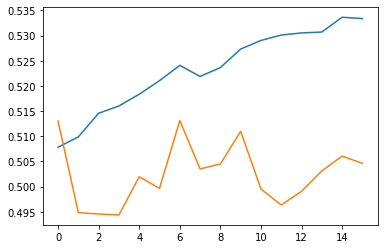

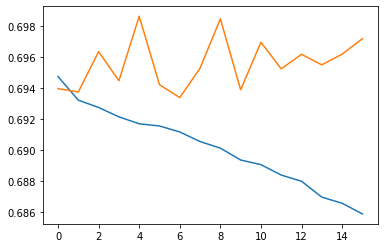

In [20]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=16,
    validation_data=(x_test, y_test),
)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [23]:
model.save('./Models/eurusd_16_ephocs.h5')

In [16]:
model = load_model('./Models/eurusd_16_ephocs.h5')

In [17]:
train_bt['prediction'] = model.predict(x_train)
test_bt['prediction'] = model.predict(x_test)
validation_bt['prediction'] = model.predict(x_val)
no_train_bt['prediction'] = model.predict(x_no_train)

/home/said/Documentos/Proyectos/GitHub/smart-markets/smenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/said/Documentos/Proyectos/GitHub/smart-markets/smenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/said/Documentos/Proyectos/GitHub/smart-markets/smenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is

In [18]:
train_bt.to_csv('./Data/EURUSD/BackTrader/train.csv')
test_bt.to_csv('./Data/EURUSD/BackTrader/test.csv')
validation_bt.to_csv('./Data/EURUSD/BackTrader/validation.csv')
no_train_bt.to_csv('./Data/EURUSD/BackTrader/NoTrain.csv')

In [19]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import backtrader as bt
import backtrader.feeds as btfeeds

In [20]:
from backtrader.feeds import GenericCSVData

class csv_with_indicators(GenericCSVData):
    lines = ('prediction',)
    params = (('prediction', 7),)

## Tomando operaciones con una sola confirmacion y cerrando luego de 5 periodos

In [87]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = dict(
        stop_loss=0.01,
        trail=None,
    )

    size = 10000
    confirmation_sma_size = 1

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To k(columns)eep track of pending orders
        self.order = None
        
        self.prediction = self.datas[0].prediction
        self.sma = bt.talib.SMA(self.data, timeperiod=12)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def next(self):
        #self.log('Close price, %f' % self.dataclose[0])

        if self.order:
            return

        if not self.position:
            
            sma_condition = []
            for x in range(0, self.confirmation_sma_size + 1):
                sma_condition.append(self.dataclose[-x] > self.sma[-x])
            
            sma_condition = list(set(sma_condition))

            if len(sma_condition) == 1:

                close_upper_sma = sma_condition[0]
                
                if self.prediction > 0.6 and close_upper_sma:
                    self.log('LONG POSITION OPEN, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.buy(size=self.size)

                elif self.prediction < 0.4 and not(close_upper_sma):
                    self.log('SHORT POSITION OPEN, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.sell(size=self.size)

        else:
            # Already in the market ... we might sell
            if len(self) > (self.bar_executed + 5):

                if self.position.size > 0:
                    self.log('LONG POSITION CLOSE, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.sell(size=self.size)

                elif self.position.size < 0:
                    self.log('SHORT POSITION CLOSE, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.buy(size=self.size)


In [99]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Create a Data Feed
data = csv_with_indicators(
    dataname='./Data/EURUSD/BackTrader/NoTrain.csv',

    #fromdate=datetime.datetime(2019, 1, 1),
    #todate=datetime.datetime(2000, 12, 31),

    nullvalue=0.0,

    dtformat=('%Y-%m-%d %H:%M:%S'),
    
    datetime=1,
    open=2,
    high=3,
    low=4,
    close=5,
    volume=6,
    prediction=7
)

cerebro.addstrategy(TestStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

cerebro.broker.setcash(100000)

# Print out the starting conditions
print('Starting Portfolio Value: %f' % cerebro.broker.getvalue())

# Run over everything
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()


# Print out the final result
print('Final Portfolio Value: %f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.000000
2017-03-03, LONG POSITION OPEN, 1.055220, 10000.000000
2017-03-04, BUY EXECUTED, 1.07
2017-03-04, LONG POSITION CLOSE, 1.067050, 10000.000000
2017-03-05, SELL EXECUTED, 1.09
2017-04-01, LONG POSITION OPEN, 1.047550, 10000.000000
2017-04-04, BUY EXECUTED, 1.07
2017-04-04, LONG POSITION CLOSE, 1.065820, 10000.000000
2017-04-05, SELL EXECUTED, 1.09
2017-04-17, LONG POSITION OPEN, 1.061740, 10000.000000
2017-04-18, BUY EXECUTED, 1.06
2017-04-18, LONG POSITION CLOSE, 1.065000, 10000.000000
2017-04-19, SELL EXECUTED, 1.07
2017-05-01, LONG POSITION OPEN, 1.059190, 10000.000000
2017-05-02, BUY EXECUTED, 1.08
2017-05-04, LONG POSITION CLOSE, 1.067770, 10000.000000
2017-05-05, SELL EXECUTED, 1.10
2017-05-15, SHORT POSITION OPEN, 1.093040, 10000.000000
2017-05-16, SELL EXECUTED, 1.10
2017-05-16, SHORT POSITION CLOSE, 1.101430, 10000.000000
2017-05-17, BUY EXECUTED, 1.11
2017-06-01, SHORT POSITION OPEN, 1.058450, 10000.000000
2017-06-02, SELL EXECUTED, 1.08


2018-11-26, LONG POSITION OPEN, 1.135690, 10000.000000
2018-11-27, BUY EXECUTED, 1.13
2018-11-27, LONG POSITION CLOSE, 1.132930, 10000.000000
2018-11-28, SELL EXECUTED, 1.13
2018-12-06, SHORT POSITION OPEN, 1.174570, 10000.000000
2018-12-07, SELL EXECUTED, 1.17
2018-12-07, SHORT POSITION CLOSE, 1.168510, 10000.000000
2018-12-08, BUY EXECUTED, 1.14
2019-01-08, LONG POSITION OPEN, 1.107880, 10000.000000
2019-01-09, BUY EXECUTED, 1.10
2019-01-10, LONG POSITION CLOSE, 1.088810, 10000.000000
2019-01-11, SELL EXECUTED, 1.12
2019-02-28, LONG POSITION OPEN, 1.137700, 10000.000000
2019-03-01, BUY EXECUTED, 1.13
2019-03-01, LONG POSITION CLOSE, 1.137270, 10000.000000
2019-03-02, SELL EXECUTED, 1.15
2019-03-09, LONG POSITION OPEN, 1.097230, 10000.000000
2019-03-10, BUY EXECUTED, 1.10
2019-03-10, LONG POSITION CLOSE, 1.094200, 10000.000000
2019-03-11, SELL EXECUTED, 1.12
2019-04-06, LONG POSITION OPEN, 1.124810, 10000.000000
2019-04-07, BUY EXECUTED, 1.13
2019-04-07, LONG POSITION CLOSE, 1.128380,

Start date,2017-03-02
End date,2020-12-08
Total months,51
,Backtest
Annual return,0.823%
Cumulative returns,3.59%
Annual volatility,0.99%
Sharpe ratio,0.83
Calmar ratio,0.92
Stability,0.94
Max drawdown,-0.891%


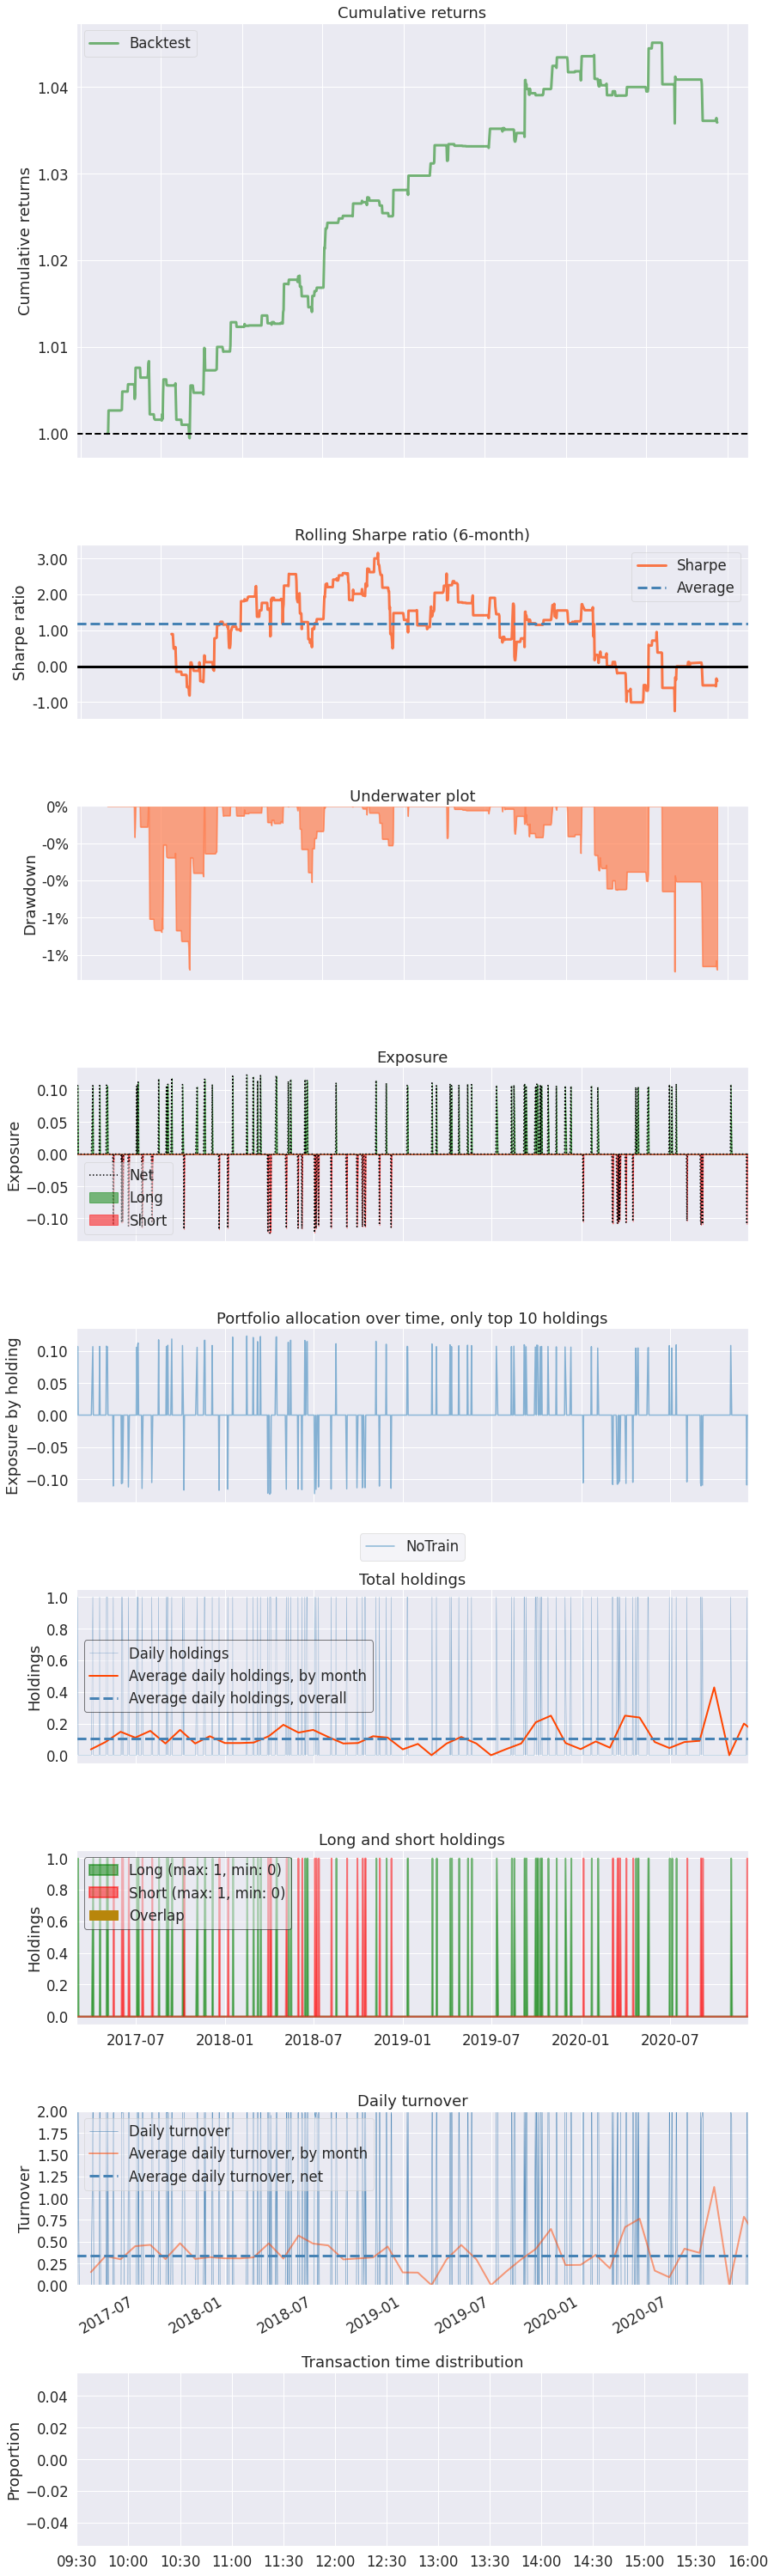

In [100]:
import pyfolio as pf
pf.create_simple_tear_sheet(returns, positions=positions, transactions=transactions)

## tomando operaciones con dos confirmaciones y cerrando en 5 periodos

In [101]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = dict(
        stop_loss=0.01,
        trail=None,
    )

    size = 10000
    confirmation_sma_size = 2

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To k(columns)eep track of pending orders
        self.order = None
        
        self.prediction = self.datas[0].prediction
        self.sma = bt.talib.SMA(self.data, timeperiod=12)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def next(self):
        #self.log('Close price, %f' % self.dataclose[0])

        if self.order:
            return

        if not self.position:
            
            sma_condition = []
            for x in range(0, self.confirmation_sma_size + 1):
                sma_condition.append(self.dataclose[-x] > self.sma[-x])
            
            sma_condition = list(set(sma_condition))

            if len(sma_condition) == 1:

                close_upper_sma = sma_condition[0]
                
                if self.prediction > 0.6 and close_upper_sma:
                    self.log('LONG POSITION OPEN, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.buy(size=self.size)

                elif self.prediction < 0.4 and not(close_upper_sma):
                    self.log('SHORT POSITION OPEN, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.sell(size=self.size)

        else:
            # Already in the market ... we might sell
            if len(self) > (self.bar_executed + 5):

                if self.position.size > 0:
                    self.log('LONG POSITION CLOSE, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.sell(size=self.size)

                elif self.position.size < 0:
                    self.log('SHORT POSITION CLOSE, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.buy(size=self.size)


In [102]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Create a Data Feed
data = csv_with_indicators(
    dataname='./Data/EURUSD/BackTrader/NoTrain.csv',

    #fromdate=datetime.datetime(2019, 1, 1),
    #todate=datetime.datetime(2000, 12, 31),

    nullvalue=0.0,

    dtformat=('%Y-%m-%d %H:%M:%S'),
    
    datetime=1,
    open=2,
    high=3,
    low=4,
    close=5,
    volume=6,
    prediction=7
)

cerebro.addstrategy(TestStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

cerebro.broker.setcash(100000)

# Print out the starting conditions
print('Starting Portfolio Value: %f' % cerebro.broker.getvalue())

# Run over everything
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()


# Print out the final result
print('Final Portfolio Value: %f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.000000
2017-03-03, LONG POSITION OPEN, 1.055220, 10000.000000
2017-03-04, BUY EXECUTED, 1.07
2017-03-04, LONG POSITION CLOSE, 1.067050, 10000.000000
2017-03-05, SELL EXECUTED, 1.09
2017-04-01, LONG POSITION OPEN, 1.047550, 10000.000000
2017-04-04, BUY EXECUTED, 1.07
2017-04-04, LONG POSITION CLOSE, 1.065820, 10000.000000
2017-04-05, SELL EXECUTED, 1.09
2017-04-17, LONG POSITION OPEN, 1.061740, 10000.000000
2017-04-18, BUY EXECUTED, 1.06
2017-04-18, LONG POSITION CLOSE, 1.065000, 10000.000000
2017-04-19, SELL EXECUTED, 1.07
2017-05-01, LONG POSITION OPEN, 1.059190, 10000.000000
2017-05-02, BUY EXECUTED, 1.08
2017-05-04, LONG POSITION CLOSE, 1.067770, 10000.000000
2017-05-05, SELL EXECUTED, 1.10
2017-05-15, SHORT POSITION OPEN, 1.093040, 10000.000000
2017-05-16, SELL EXECUTED, 1.10
2017-05-16, SHORT POSITION CLOSE, 1.101430, 10000.000000
2017-05-17, BUY EXECUTED, 1.11
2017-06-01, SHORT POSITION OPEN, 1.058450, 10000.000000
2017-06-02, SELL EXECUTED, 1.08


2018-08-05, SHORT POSITION OPEN, 1.185330, 10000.000000
2018-08-06, SELL EXECUTED, 1.18
2018-08-06, SHORT POSITION CLOSE, 1.177800, 10000.000000
2018-08-07, BUY EXECUTED, 1.17
2018-08-15, LONG POSITION OPEN, 1.134190, 10000.000000
2018-08-16, BUY EXECUTED, 1.13
2018-08-16, LONG POSITION CLOSE, 1.137530, 10000.000000
2018-08-17, SELL EXECUTED, 1.14
2018-09-01, LONG POSITION OPEN, 1.197300, 10000.000000
2018-09-02, BUY EXECUTED, 1.23
2018-09-02, LONG POSITION CLOSE, 1.226570, 10000.000000
2018-09-03, SELL EXECUTED, 1.23
2018-09-05, SHORT POSITION OPEN, 1.185630, 10000.000000
2018-09-07, SELL EXECUTED, 1.18
2018-09-07, SHORT POSITION CLOSE, 1.176480, 10000.000000
2018-09-08, BUY EXECUTED, 1.16
2018-09-27, SHORT POSITION OPEN, 1.171160, 10000.000000
2018-09-28, SELL EXECUTED, 1.16
2018-09-28, SHORT POSITION CLOSE, 1.162640, 10000.000000
2018-09-30, BUY EXECUTED, 1.16
2018-10-08, SHORT POSITION OPEN, 1.145700, 10000.000000
2018-10-09, SELL EXECUTED, 1.16
2018-10-09, SHORT POSITION CLOSE, 1.

2020-04-23, SELL EXECUTED, 1.08
2020-04-24, LONG POSITION OPEN, 1.078850, 10000.000000
2020-04-26, BUY EXECUTED, 1.08
2020-04-27, LONG POSITION CLOSE, 1.083200, 10000.000000
2020-04-28, SELL EXECUTED, 1.08
2020-05-14, LONG POSITION OPEN, 1.080730, 10000.000000
2020-05-15, BUY EXECUTED, 1.08
2020-05-15, LONG POSITION CLOSE, 1.079940, 10000.000000
2020-05-17, SELL EXECUTED, 1.08
2020-06-02, LONG POSITION OPEN, 1.100180, 10000.000000
2020-06-03, BUY EXECUTED, 1.12
2020-06-03, LONG POSITION CLOSE, 1.122860, 10000.000000
2020-06-04, SELL EXECUTED, 1.08
2020-06-05, LONG POSITION OPEN, 1.083860, 10000.000000
2020-06-07, BUY EXECUTED, 1.12
2020-06-07, LONG POSITION CLOSE, 1.129170, 10000.000000
2020-06-08, SELL EXECUTED, 1.19
2020-06-29, LONG POSITION OPEN, 1.122960, 10000.000000
2020-06-30, BUY EXECUTED, 1.12
2020-06-30, LONG POSITION CLOSE, 1.121320, 10000.000000
2020-07-01, SELL EXECUTED, 1.12
2020-07-04, LONG POSITION OPEN, 1.090280, 10000.000000
2020-07-05, BUY EXECUTED, 1.08
2020-07-05, 

Start date,2017-03-02
End date,2020-12-08
Total months,51
,Backtest
Annual return,1.024%
Cumulative returns,4.483%
Annual volatility,1.106%
Sharpe ratio,0.93
Calmar ratio,1.15
Stability,0.93
Max drawdown,-0.888%


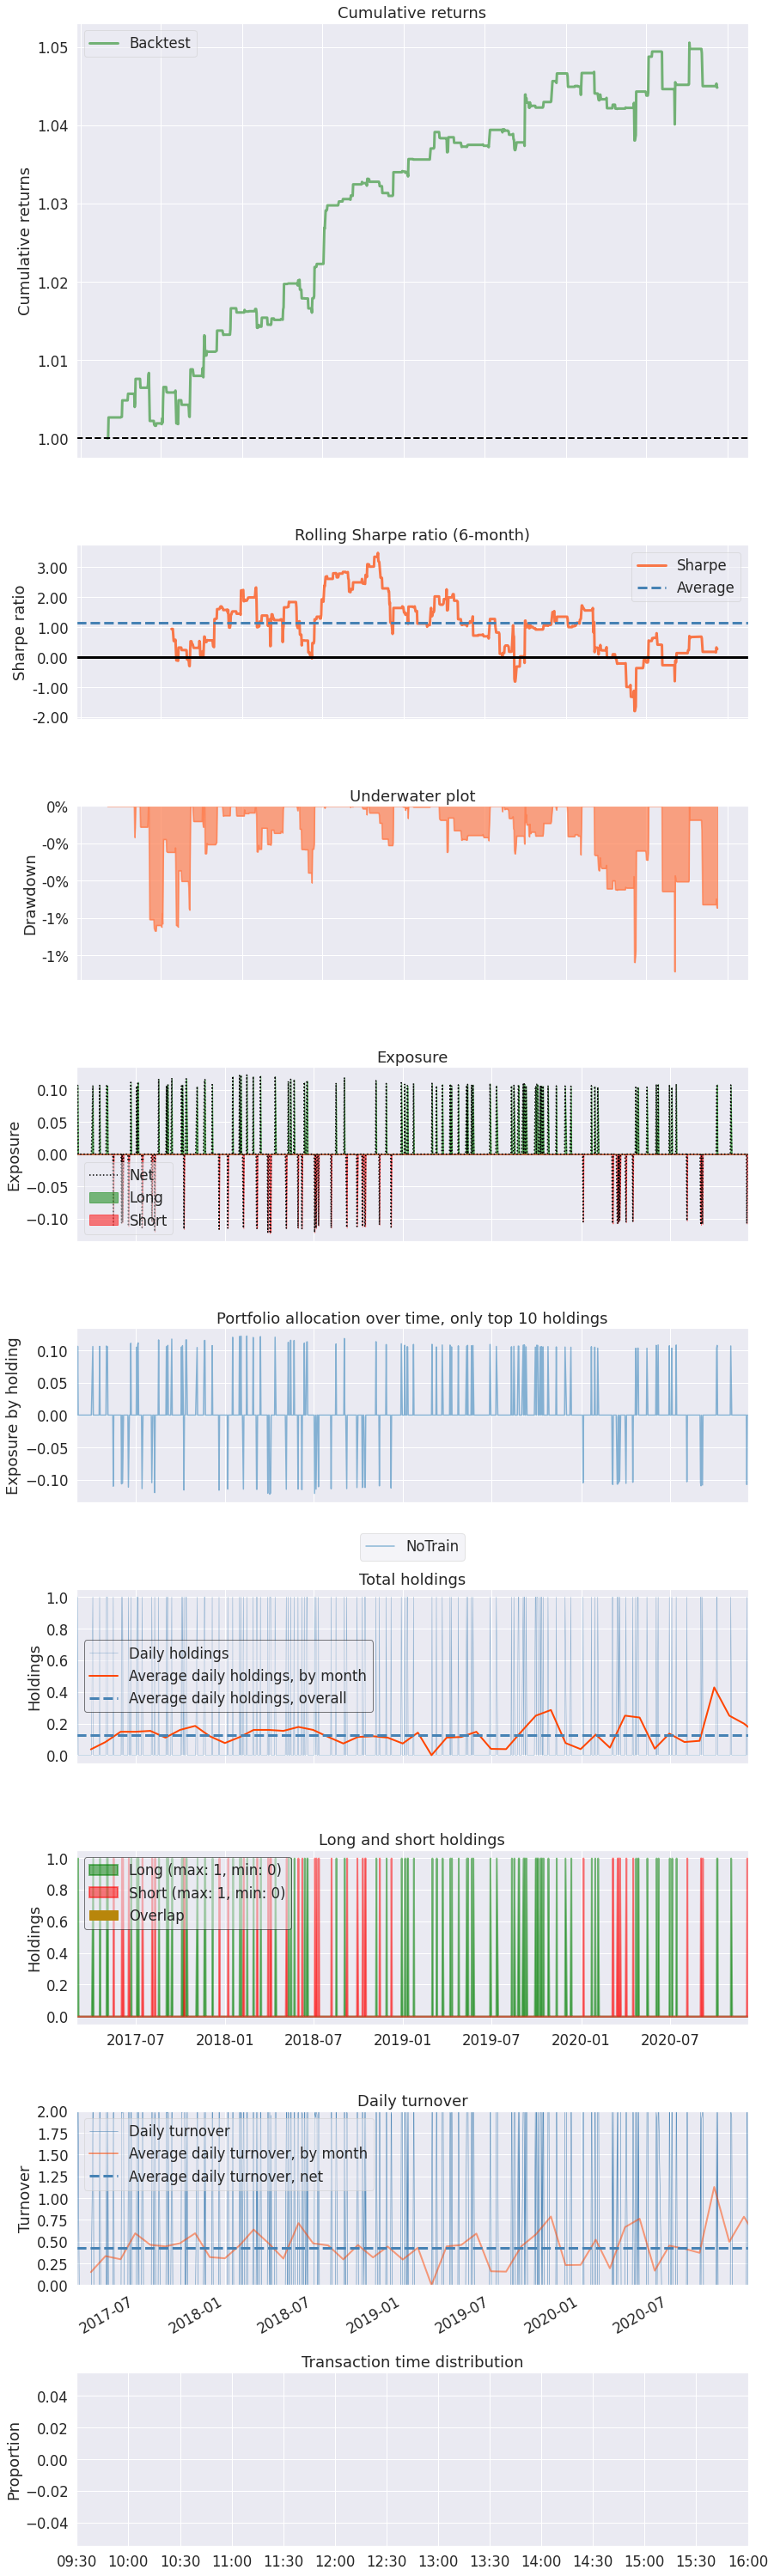

In [103]:
pf.create_simple_tear_sheet(returns, positions=positions, transactions=transactions)

## tomando operaciones con tres confirmaciones y cerrando en 5 periodos

In [104]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = dict(
        stop_loss=0.01,
        trail=None,
    )

    size = 10000
    confirmation_sma_size = 3

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To k(columns)eep track of pending orders
        self.order = None
        
        self.prediction = self.datas[0].prediction
        self.sma = bt.talib.SMA(self.data, timeperiod=12)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def next(self):
        #self.log('Close price, %f' % self.dataclose[0])

        if self.order:
            return

        if not self.position:
            
            sma_condition = []
            for x in range(0, self.confirmation_sma_size + 1):
                sma_condition.append(self.dataclose[-x] > self.sma[-x])
            
            sma_condition = list(set(sma_condition))

            if len(sma_condition) == 1:

                close_upper_sma = sma_condition[0]
                
                if self.prediction > 0.6 and close_upper_sma:
                    self.log('LONG POSITION OPEN, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.buy(size=self.size)

                elif self.prediction < 0.4 and not(close_upper_sma):
                    self.log('SHORT POSITION OPEN, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.sell(size=self.size)

        else:
            # Already in the market ... we might sell
            if len(self) > (self.bar_executed + 5):

                if self.position.size > 0:
                    self.log('LONG POSITION CLOSE, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.sell(size=self.size)

                elif self.position.size < 0:
                    self.log('SHORT POSITION CLOSE, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.buy(size=self.size)


In [105]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Create a Data Feed
data = csv_with_indicators(
    dataname='./Data/EURUSD/BackTrader/NoTrain.csv',

    #fromdate=datetime.datetime(2019, 1, 1),
    #todate=datetime.datetime(2000, 12, 31),

    nullvalue=0.0,

    dtformat=('%Y-%m-%d %H:%M:%S'),
    
    datetime=1,
    open=2,
    high=3,
    low=4,
    close=5,
    volume=6,
    prediction=7
)

cerebro.addstrategy(TestStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

cerebro.broker.setcash(100000)

# Print out the starting conditions
print('Starting Portfolio Value: %f' % cerebro.broker.getvalue())

# Run over everything
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()


# Print out the final result
print('Final Portfolio Value: %f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.000000
2017-03-03, LONG POSITION OPEN, 1.055220, 10000.000000
2017-03-04, BUY EXECUTED, 1.07
2017-03-04, LONG POSITION CLOSE, 1.067050, 10000.000000
2017-03-05, SELL EXECUTED, 1.09
2017-04-01, LONG POSITION OPEN, 1.047550, 10000.000000
2017-04-04, BUY EXECUTED, 1.07
2017-04-04, LONG POSITION CLOSE, 1.065820, 10000.000000
2017-04-05, SELL EXECUTED, 1.09
2017-04-17, LONG POSITION OPEN, 1.061740, 10000.000000
2017-04-18, BUY EXECUTED, 1.06
2017-04-18, LONG POSITION CLOSE, 1.065000, 10000.000000
2017-04-19, SELL EXECUTED, 1.07
2017-05-01, LONG POSITION OPEN, 1.059190, 10000.000000
2017-05-02, BUY EXECUTED, 1.08
2017-05-04, LONG POSITION CLOSE, 1.067770, 10000.000000
2017-05-05, SELL EXECUTED, 1.10
2017-05-15, SHORT POSITION OPEN, 1.093040, 10000.000000
2017-05-16, SELL EXECUTED, 1.10
2017-05-16, SHORT POSITION CLOSE, 1.101430, 10000.000000
2017-05-17, BUY EXECUTED, 1.11
2017-06-01, SHORT POSITION OPEN, 1.058450, 10000.000000
2017-06-02, SELL EXECUTED, 1.08


2018-09-05, SHORT POSITION OPEN, 1.185630, 10000.000000
2018-09-07, SELL EXECUTED, 1.18
2018-09-07, SHORT POSITION CLOSE, 1.176480, 10000.000000
2018-09-08, BUY EXECUTED, 1.16
2018-09-27, SHORT POSITION OPEN, 1.171160, 10000.000000
2018-09-28, SELL EXECUTED, 1.16
2018-09-28, SHORT POSITION CLOSE, 1.162640, 10000.000000
2018-09-30, BUY EXECUTED, 1.16
2018-10-08, SHORT POSITION OPEN, 1.145700, 10000.000000
2018-10-09, SELL EXECUTED, 1.16
2018-10-09, SHORT POSITION CLOSE, 1.153280, 10000.000000
2018-10-10, BUY EXECUTED, 1.15
2018-10-12, SHORT POSITION OPEN, 1.140970, 10000.000000
2018-10-14, SELL EXECUTED, 1.15
2018-10-15, SHORT POSITION CLOSE, 1.154760, 10000.000000
2018-10-16, BUY EXECUTED, 1.16
2018-11-05, LONG POSITION OPEN, 1.194390, 10000.000000
2018-11-06, BUY EXECUTED, 1.18
2018-11-06, LONG POSITION CLOSE, 1.180760, 10000.000000
2018-11-07, SELL EXECUTED, 1.17
2018-11-12, SHORT POSITION OPEN, 1.136830, 10000.000000
2018-11-13, SELL EXECUTED, 1.12
2018-11-13, SHORT POSITION CLOSE, 

2020-06-29, LONG POSITION OPEN, 1.122960, 10000.000000
2020-06-30, BUY EXECUTED, 1.12
2020-06-30, LONG POSITION CLOSE, 1.121320, 10000.000000
2020-07-01, SELL EXECUTED, 1.12
2020-07-04, LONG POSITION OPEN, 1.090280, 10000.000000
2020-07-05, BUY EXECUTED, 1.08
2020-07-05, LONG POSITION CLOSE, 1.079250, 10000.000000
2020-07-06, SELL EXECUTED, 1.13
2020-07-13, LONG POSITION OPEN, 1.136780, 10000.000000
2020-07-14, BUY EXECUTED, 1.13
2020-07-14, LONG POSITION CLOSE, 1.134310, 10000.000000
2020-07-15, SELL EXECUTED, 1.14
2020-08-04, SHORT POSITION OPEN, 1.087180, 10000.000000
2020-08-05, SELL EXECUTED, 1.08
2020-08-05, SHORT POSITION CLOSE, 1.083390, 10000.000000
2020-08-06, BUY EXECUTED, 1.13
2020-09-01, SHORT POSITION OPEN, 1.111540, 10000.000000
2020-09-02, SELL EXECUTED, 1.09
2020-09-03, SHORT POSITION CLOSE, 1.140180, 10000.000000
2020-09-04, BUY EXECUTED, 1.09
2020-09-04, SHORT POSITION OPEN, 1.086950, 10000.000000
2020-09-06, SELL EXECUTED, 1.13
2020-09-06, SHORT POSITION CLOSE, 1.12

Start date,2017-03-02
End date,2020-12-08
Total months,51
,Backtest
Annual return,0.976%
Cumulative returns,4.272%
Annual volatility,1.048%
Sharpe ratio,0.93
Calmar ratio,1.10
Stability,0.93
Max drawdown,-0.89%


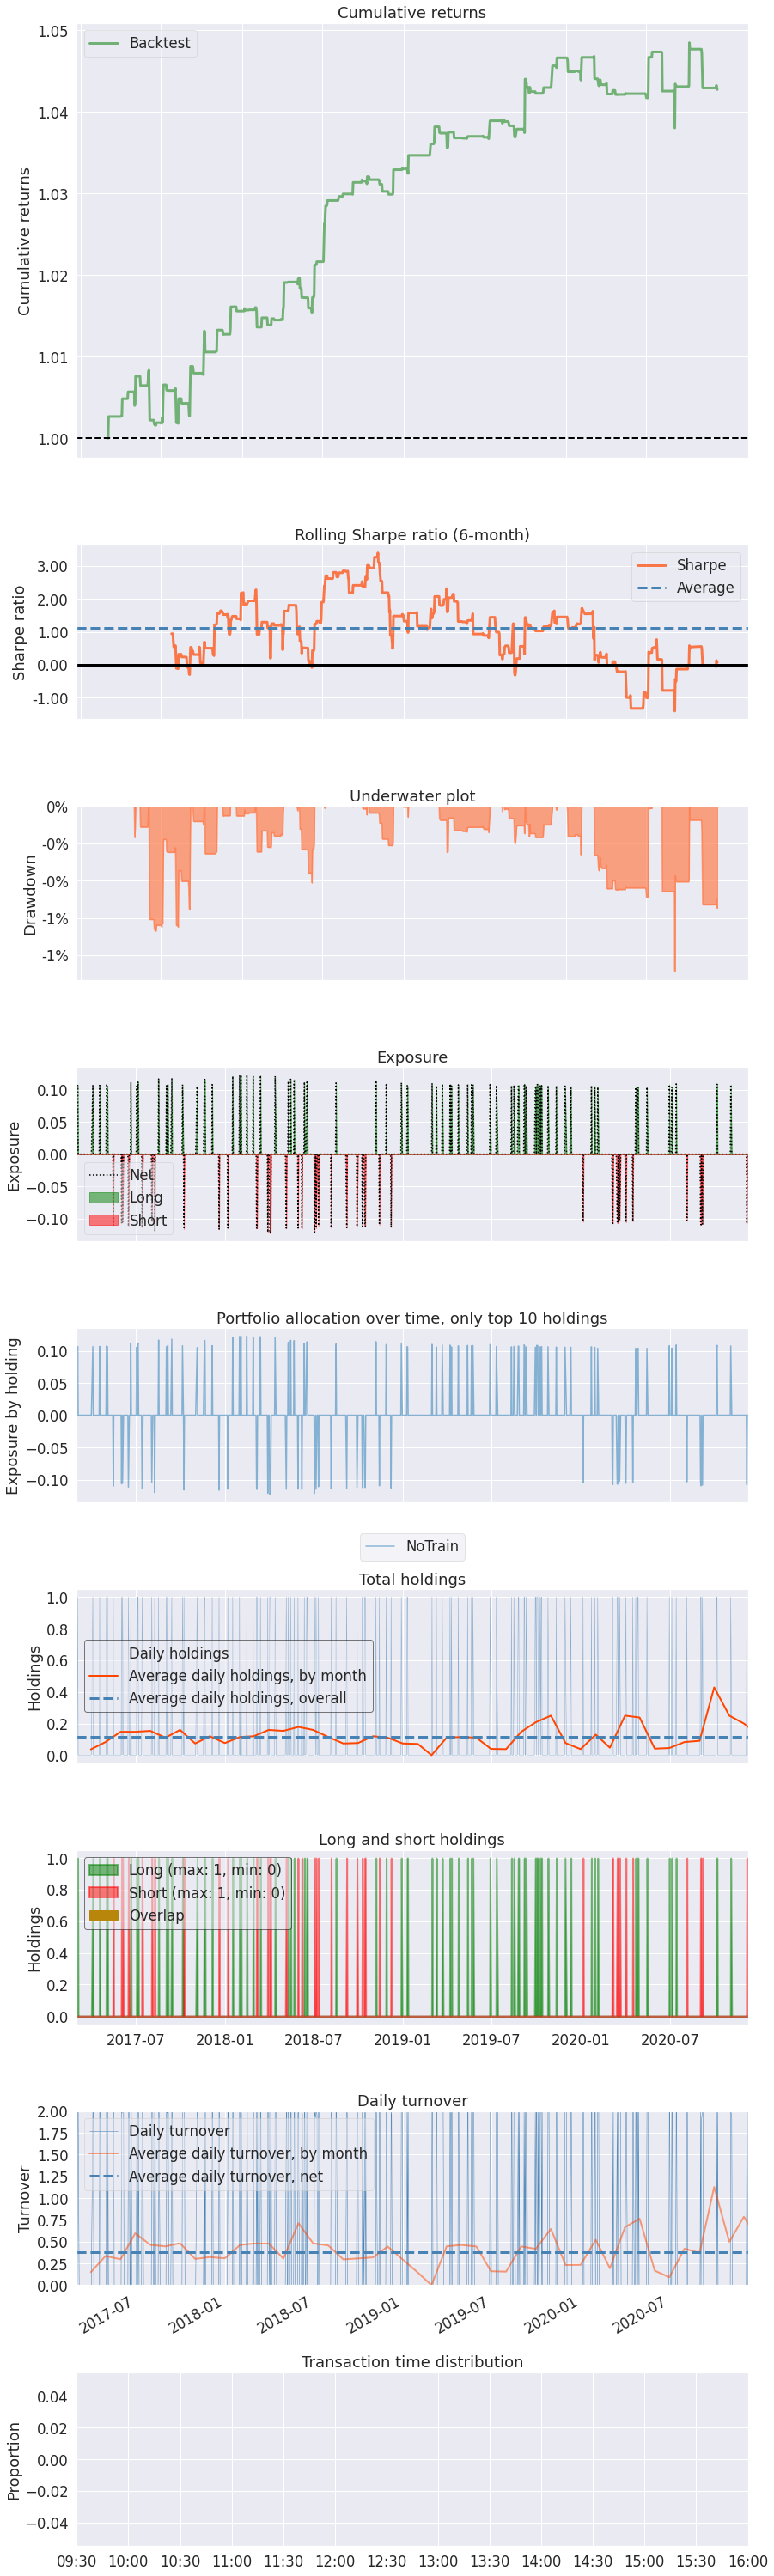

In [106]:
pf.create_simple_tear_sheet(returns, positions=positions, transactions=transactions)

## Anadiendo stop loss

## tomando operaciones con tres confirmaciones y cerrando en 5 periodos

In [113]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = dict(
        stop_loss=0.01,
        trail=None,
    )

    size = 10000
    confirmation_sma_size = 3

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        self.order = None
        self.prediction = self.datas[0].prediction
        self.sma = bt.talib.SMA(self.data, timeperiod=12)

    def notify_order(self, order):
        if order.status == order.Cancelled:
            print('CANCEL@price: {:.2f} {}'.format(
                order.executed.price, 'buy' if order.isbuy() else 'sell'))
            return

        if not order.status == order.Completed:
            return  # discard any other notification

        if not self.position:  # we left the market
            print('SELL@price: {:.f}'.format(order.executed.price))
            return

        # We have entered the market
        print('BUY @price: {:.f}'.format(order.executed.price))


    def next(self):
        #self.log('Close price, %f' % self.dataclose[0])

        if self.order:
            return

        if not self.position:
            
            sma_condition = []
            for x in range(0, self.confirmation_sma_size + 1):
                sma_condition.append(self.dataclose[-x] > self.sma[-x])
            
            sma_condition = list(set(sma_condition))

            if len(sma_condition) == 1:

                close_upper_sma = sma_condition[0]
                
                if self.prediction > 0.6 and close_upper_sma:
                    self.log('LONG POSITION OPEN, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.buy(size=self.size)

                elif self.prediction < 0.4 and not(close_upper_sma):
                    self.log('SHORT POSITION OPEN, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.sell(size=self.size)

        else:
            # Already in the market ... we might sell
            if len(self) > (self.bar_executed + 5):

                if self.position.size > 0:
                    self.log('LONG POSITION CLOSE, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.sell(size=self.size)

                elif self.position.size < 0:
                    self.log('SHORT POSITION CLOSE, %f, %f' % (self.dataclose[0], self.size))
                    self.order = self.buy(size=self.size)


In [114]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Create a Data Feed
data = csv_with_indicators(
    dataname='./Data/EURUSD/BackTrader/NoTrain.csv',

    #fromdate=datetime.datetime(2019, 1, 1),
    #todate=datetime.datetime(2000, 12, 31),

    nullvalue=0.0,

    dtformat=('%Y-%m-%d %H:%M:%S'),
    
    datetime=1,
    open=2,
    high=3,
    low=4,
    close=5,
    volume=6,
    prediction=7
)

cerebro.addstrategy(TestStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

cerebro.broker.setcash(100000)

# Print out the starting conditions
print('Starting Portfolio Value: %f' % cerebro.broker.getvalue())

# Run over everything
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()


# Print out the final result
print('Final Portfolio Value: %f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.000000
2017-04-01, LONG POSITION OPEN, 1.047850, 10000.000000
2017-04-04, BUY EXECUTED, 1.07
2017-04-04, LONG POSITION CLOSE, 1.065820, 10000.000000
2017-04-05, SELL EXECUTED, 1.09
2017-05-15, LONG POSITION OPEN, 1.096980, 10000.000000
2017-05-16, BUY EXECUTED, 1.10
2017-05-16, LONG POSITION CLOSE, 1.101430, 10000.000000
2017-05-17, SELL EXECUTED, 1.11
2017-07-02, LONG POSITION OPEN, 1.068370, 10000.000000
2017-07-03, BUY EXECUTED, 1.06
2017-07-03, LONG POSITION CLOSE, 1.058570, 10000.000000
2017-07-04, SELL EXECUTED, 1.06
2017-08-02, LONG POSITION OPEN, 1.068660, 10000.000000
2017-08-03, BUY EXECUTED, 1.06
2017-08-03, LONG POSITION CLOSE, 1.056590, 10000.000000
2017-08-05, SELL EXECUTED, 1.10
2017-09-01, LONG POSITION OPEN, 1.057500, 10000.000000
2017-09-02, BUY EXECUTED, 1.07
2017-09-02, LONG POSITION CLOSE, 1.067280, 10000.000000
2017-09-03, SELL EXECUTED, 1.05
2017-09-03, LONG POSITION OPEN, 1.058020, 10000.000000
2017-09-04, BUY EXECUTED, 1.06
2017

/home/said/Documentos/Proyectos/GitHub/smart-markets/smenv/lib/python3.6/site-packages/empyrical/stats.py:1526: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2017-03-02
End date,2020-12-08
Total months,51
,Backtest
Annual return,0.462%
Cumulative returns,2.006%
Annual volatility,0.551%
Sharpe ratio,0.84
Calmar ratio,0.99
Stability,0.58
Max drawdown,-0.465%


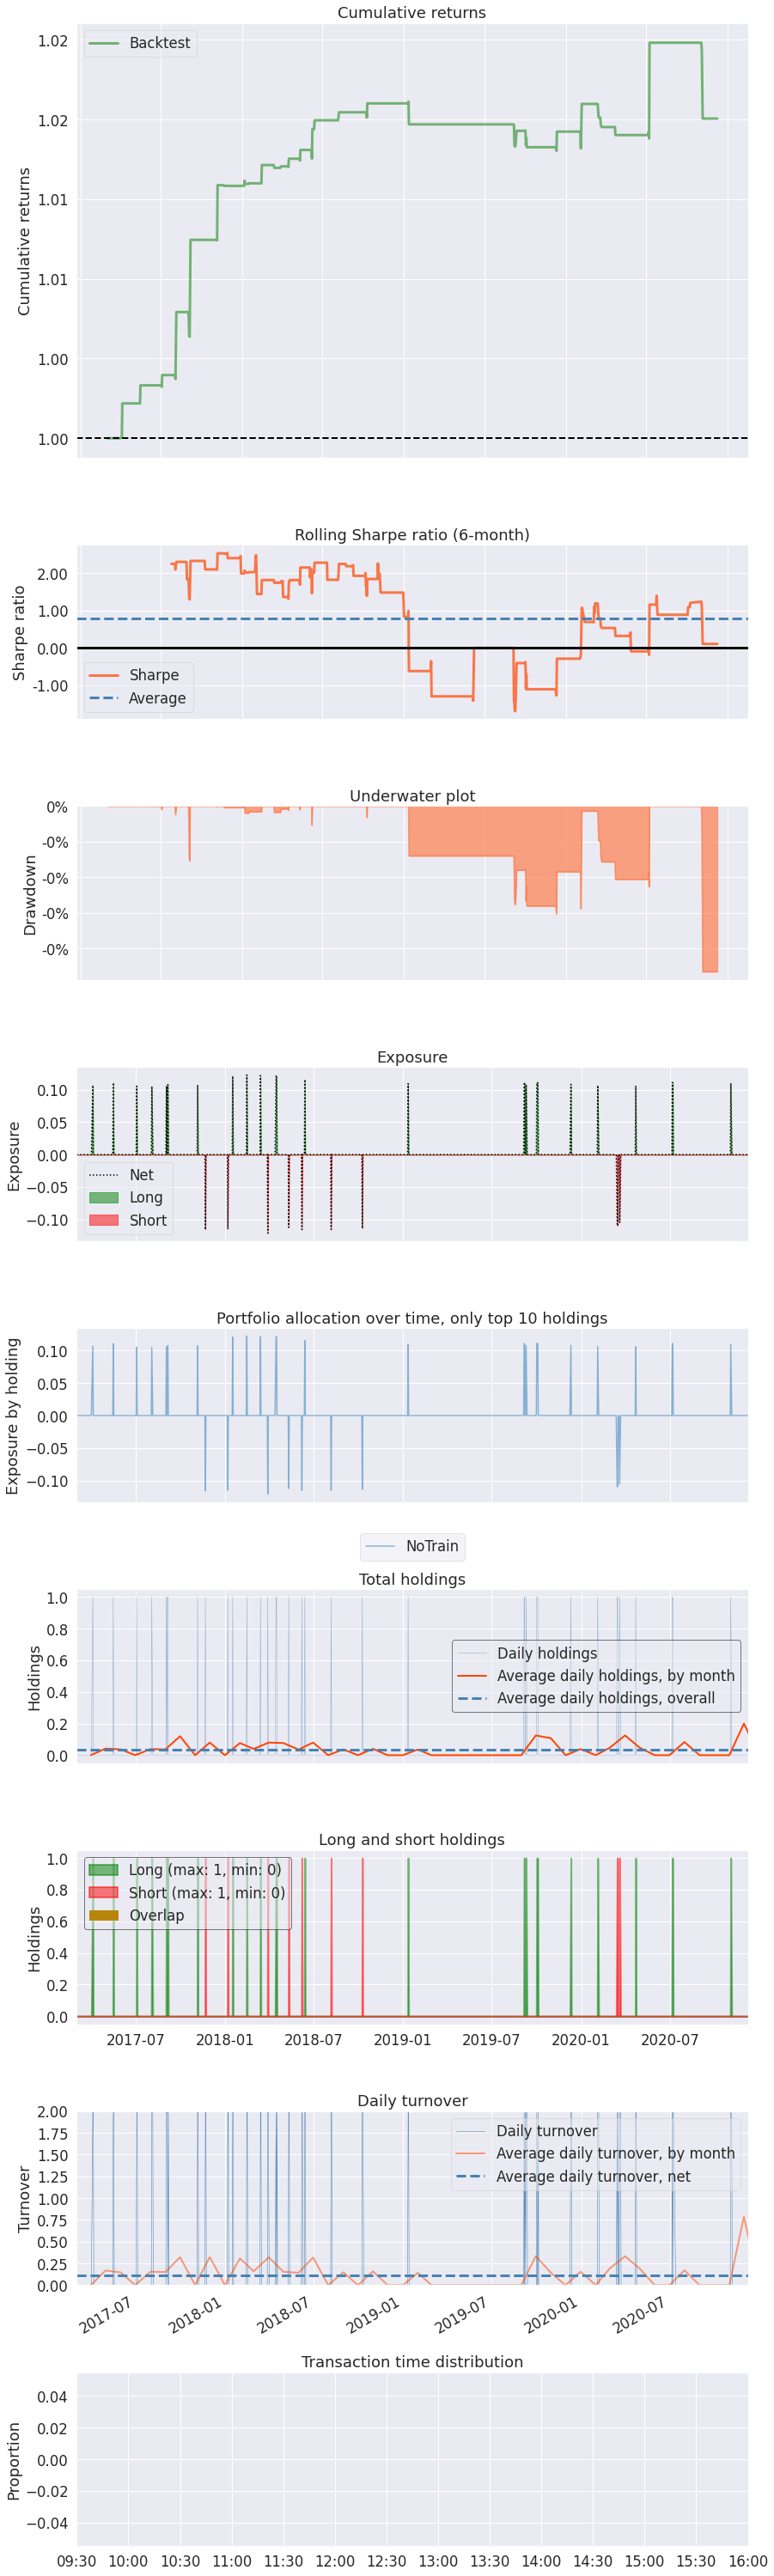

In [115]:
pf.create_simple_tear_sheet(returns, positions=positions, transactions=transactions)